In [1]:
import os

import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


torch.manual_seed(1)
logging.basicConfig(level=logging.DEBUG, format='%(name)s - %(levelname)s - %(message)s')

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TFHUB_CACHE_DIR"]="tfhub_modules"

matplotlib.backends - DEBUG - backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
class ISEARDataset(object):
  FILENAME = "data/isear_databank.csv"
  EMOTION_CLASSES = ["anger", "disgust", "fear", "guilt", "joy", "sadness", "shame"]
  EMOTION_CLASSES_DICT = {"anger": 0, "disgust": 1, "fear": 2, "guilt": 3, "joy": 4, "sadness": 5, "shame": 6}
  RANDOM_STATE = 41
  
  def get_classes(self):
    return self.EMOTION_CLASSES
  
  def get_classes_dict(self):
    return self.EMOTION_CLASSES_DICT
  
  def __load_data_file(self):
    data = pd.read_csv(self.FILENAME)
    data["emotion"] = data["Field1"]
    data["text"] = data["SIT"]
    return data[["text", "emotion"]]

  def load_data(self):
    train_data = None
    test_data = None
    
    data = self.__load_data_file()
    
    train_data, test_data = train_test_split(data, test_size=0.3, random_state=self.RANDOM_STATE, stratify=data["emotion"].values)
    return train_data, test_data

In [3]:
isear_dataset = ISEARDataset()
train_data, test_data = isear_dataset.load_data()
train_data, valid_data = train_test_split(train_data, test_size=0.1, random_state=200, stratify=train_data.emotion)

logging.debug("train_data.shape: (%d, %d)" % train_data.shape)
logging.debug("valid_data.shape: (%d, %d)" % valid_data.shape)
logging.debug("test_data.shape: (%d, %d)" % test_data.shape)

root - DEBUG - train_data.shape: (4829, 2)
root - DEBUG - valid_data.shape: (537, 2)
root - DEBUG - test_data.shape: (2300, 2)


root - DEBUG - class dictionary: {'anger': 0, 'disgust': 1, 'fear': 2, 'guilt': 3, 'joy': 4, 'sadness': 5, 'shame': 6}
root - DEBUG - class labels: ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']
root - DEBUG - number of bins: 7
matplotlib.font_manager - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
matplotlib.font_manager - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


bins: [0, 1, 2, 3, 4, 5, 6, 7]


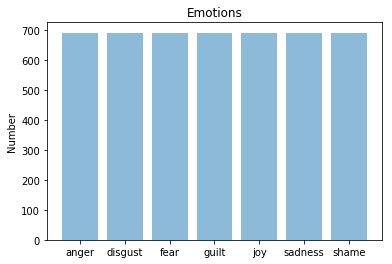

In [4]:
dic = isear_dataset.get_classes_dict()
labels = isear_dataset.get_classes()
n_classes = len(labels)
logging.debug("class dictionary: %s" % dic)
logging.debug("class labels: %s" % labels)
logging.debug("number of bins: %s" % n_classes)

for emotion in labels:
  train_data.loc[train_data.emotion == emotion, "emotion_int"] = dic[emotion]
  valid_data.loc[valid_data.emotion == emotion, "emotion_int"] = dic[emotion]
  test_data.loc[test_data.emotion == emotion, "emotion_int"] = dic[emotion]

bins = list(range(0, n_classes + 1))
print("bins:", bins)
hist, _ = np.histogram(train_data["emotion_int"], bins=bins)

y_pos = np.arange(len(labels))

plt.bar(y_pos, hist, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('Number')
plt.title('Emotions')
 
plt.show()

In [7]:
from allennlp.modules.elmo import Elmo, batch_to_ids

options_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_options.json"
weight_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_weights.hdf5"

# Compute two different representation for each token.
# Each representation is a linear weighted combination for the
# 3 layers in ELMo (i.e., charcnn, the outputs of the two BiLSTM))
elmo = Elmo(options_file, weight_file, num_output_representations=1, dropout=0)

# use batch_to_ids to convert sentences to character ids
sentences = [["I", "ate", "an", "apple", "for", "breakfast"], ["I", "ate", "a", "carrot", "for", "breakfast"]]
character_ids = batch_to_ids(sentences)

embeddings = elmo(character_ids)

embeddings

allennlp.modules.seq2seq_encoders - DEBUG - allennlp could not register 'alternating_highway_lstm_cuda' - installation needs to be completed manually if you have pip-installed the package. Run ``bash make.sh`` in the 'custom_extensions' module on a machine with a GPU.
allennlp.modules.elmo - INFO - Initializing ELMo
urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): s3-us-west-2.amazonaws.com:443
urllib3.connectionpool - DEBUG - https://s3-us-west-2.amazonaws.com:443 "HEAD /allennlp/models/elmo/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_options.json HTTP/1.1" 200 0
urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): s3-us-west-2.amazonaws.com:443
urllib3.connectionpool - DEBUG - https://s3-us-west-2.amazonaws.com:443 "HEAD /allennlp/models/elmo/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_weights.hdf5 HTTP/1.1" 200 0
urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): s3-us-west-2.amazonaws.com:443
u

{'elmo_representations': [tensor([[[ 4.3756e-01, -4.8623e-01, -9.5745e-04,  ...,  9.7785e-02,
             1.4836e-01,  4.3901e-03],
           [ 7.1112e-02,  2.7539e-01, -3.6213e-01,  ...,  3.9166e-02,
            -1.6154e-01, -8.9053e-02],
           [ 2.8289e-01,  1.0413e+00, -4.2083e-01,  ...,  4.5400e-01,
             2.5717e-01,  3.9710e-01],
           [-4.2325e-01,  3.1289e-01, -3.4542e-01,  ...,  2.5908e-01,
             5.9813e-01,  2.5162e-01],
           [ 1.0569e-01,  1.1877e-01, -3.2079e-01,  ..., -2.7252e-01,
            -1.0665e-03,  2.2316e-01],
           [-4.7895e-01,  5.6897e-01,  2.3329e-01,  ..., -4.6209e-01,
            -4.3714e-01, -1.4972e-01]],
  
          [[ 4.3756e-01, -4.8623e-01, -9.5757e-04,  ...,  1.8139e-01,
             1.6335e-01,  7.9839e-02],
           [ 7.1112e-02,  2.7539e-01, -3.6213e-01,  ...,  1.0907e-01,
            -1.3844e-01,  3.8415e-02],
           [-1.2256e-01,  8.0256e-02, -1.3381e-01,  ...,  3.6823e-01,
             2.1741e-01,  2.84

In [8]:
embeddings['elmo_representations'][0][0][3]

tensor([-4.2325e-01,  3.1289e-01, -3.4542e-01, -3.1014e-01, -5.6415e-01,
        -1.8240e-01,  5.5703e-01, -5.3180e-01,  6.4167e-01,  3.5408e-02,
        -5.3202e-01, -5.9440e-01, -5.9428e-01, -4.6132e-01,  2.1338e-01,
         9.8465e-02,  6.0334e-01, -1.9126e-02,  5.6934e-01,  7.6625e-01,
         1.8691e-01,  9.8496e-02, -2.3313e-01, -4.2633e-01, -9.6580e-01,
        -2.7636e-01, -1.0689e-01,  5.1652e-01,  1.8732e-01,  1.8302e-01,
        -8.5062e-02,  3.2676e-01,  4.3260e-01,  2.4236e-01,  8.9615e-02,
         6.6932e-01, -8.4051e-02, -6.8439e-01, -1.4887e-01,  3.0480e-02,
         9.7660e-02, -3.7491e-01, -2.6952e-01, -1.0879e+00,  2.2349e-01,
        -1.1638e-03, -9.2463e-01,  6.5309e-01,  2.9771e-01,  4.0277e-01,
        -1.9363e-01,  9.1250e-02,  1.0957e+00, -1.2587e-01, -1.3668e+00,
         1.0718e+00, -4.0975e-01,  1.6330e-01,  9.2373e-02,  4.3808e-01,
         1.9901e-01,  1.2635e+00,  2.9335e-02,  7.8514e-01, -7.5447e-01,
         2.8829e-01,  1.3557e+00, -1.6016e+00, -5.1

In [9]:
embeddings['elmo_representations'][0][1][3]

tensor([ 0.1100, -0.0816,  0.3199, -0.3158, -0.2770, -0.0410,  0.3335, -0.6008,
         0.3870, -0.3189,  0.0527, -0.4956, -0.3350, -0.6907, -0.2297,  0.2915,
         0.1208, -0.3877,  0.2383,  0.4437, -0.4679,  0.3230, -0.2592, -0.4862,
        -1.1312,  0.2357,  0.0278, -0.0308, -0.1074,  0.2662, -0.2661,  0.4266,
         0.2657, -0.0820,  0.3471,  0.7010, -0.2093, -0.5405,  0.1320, -0.2795,
         0.1999, -0.3326,  0.1666, -1.1544,  0.3103,  0.0448, -0.6981,  0.3170,
         0.0020,  0.4104, -0.3225,  0.4023,  0.3601,  0.0578, -0.6622,  0.8963,
        -0.0778,  0.1298,  0.0583,  0.3888,  0.5428,  1.5588, -0.0441,  0.9767,
        -0.9032,  0.3454,  1.0624, -1.4201, -0.9866,  0.0631, -0.0450, -0.1062,
        -0.0438, -0.0686,  0.4281, -1.0498,  0.1070,  0.1514,  0.3638,  0.2343,
         0.4350,  0.0624,  0.1309,  0.4906, -0.3815, -0.9005, -0.8931, -0.3780,
        -0.1412, -0.1676,  0.7581,  0.3118, -0.1093, -0.1344, -0.3957, -0.1400,
         0.3408, -0.9079, -0.0894, -0.38

In [10]:
from scipy.spatial.distance import cosine

vectors = embeddings['elmo_representations'][0].detach().numpy()
cosine(vectors[0][3], vectors[1][3])

0.22028756141662598

In [11]:
cosine(vectors[0][5], vectors[1][5])

0.004648745059967041

In [12]:
from nltk import word_tokenize

train_character_ids = batch_to_ids(train_data.text[0:10])

embeddings = elmo(train_character_ids)

embeddings

{'elmo_representations': [tensor([[[ 2.4977e-01, -6.6283e-02,  2.1410e-02,  ..., -4.8233e-02,
             1.8866e-01, -2.8295e-01],
           [ 1.1351e-01, -2.4031e-01,  3.6148e-01,  ...,  4.8067e-02,
            -2.3969e-03, -2.0045e-01],
           [ 4.9011e-01, -5.8767e-01,  2.2363e-01,  ...,  2.1993e-01,
             1.3822e-01,  9.4120e-02],
           ...,
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00]],
  
          [[-1.0334e-01,  1.2403e+00, -5.4524e-02,  ...,  3.4440e-01,
             2.6005e-01, -7.2842e-02],
           [ 4.6890e-01, -4.0811e-01, -2.3620e-01,  ..., -2.1398e-02,
             1.6214e-01, -1.5590e-01],
           [ 9.6651e-02,  2.4398e-01,  1.5075e-02,  ...,  2.9042e-01,
            -2

In [13]:
embeddings['elmo_representations'][0].detach().numpy().shape

(10, 280, 256)

In [5]:
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(1, 1, self.hidden_dim),
                torch.zeros(1, 1, self.hidden_dim))

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, self.hidden = self.lstm(
            embeds.view(len(sentence), 1, -1), self.hidden)
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [6]:
model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

NameError: name 'EMBEDDING_DIM' is not defined